In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from sklearn.cluster import KMeans
from sklearn.model_selection import cross_val_score

In [3]:
from xgboost import XGBRegressor

In [4]:
class Course:
    @staticmethod
    def init_plt():
        plt.style.use("seaborn-whitegrid")
        plt.rc("figure", autolayout=True)
        plt.rc("axes", labelweight="bold", labelsize="large", titleweight="bold", titlesize=14, titlepad=10)

    @staticmethod
    def load_data():
        df = pd.read_csv("../../input/fe-course-data/housing.csv")
        X = df.copy()
        y = X.pop("MedHouseVal")
        return df, X, y

    @staticmethod
    def factorize_object_and_category(X):
        for col_name in X.select_dtypes(["object", "category"]):
            X[col_name], _ = X[col_name].factorize()
        return X

    @staticmethod
    def get_scaled_features(X, features):
        X_scaled = X.loc[:, features]
        X_scaled = (X_scaled - X_scaled.mean(axis=0)) / X_scaled.std(axis=0)
        return X_scaled

    @staticmethod
    def train(X, n_clusters=10, max_iter=10):
        # Create cluster feature
        k_means = KMeans(n_clusters=n_clusters, max_iter=max_iter, random_state=0)
        X["Cluster"] = k_means.fit_predict(X)
        # 原本是 int32
        X["Cluster"] = X["Cluster"].astype("category")
        # 显示不同 Cluster 下 (Longitude, Latitude) 的分布
        sns.relplot(x="Longitude", y="Latitude", hue="Cluster", data=X, height=6)
        # 显示不同 Cluster 下 MedHouseVal 的箱线图
        sns.catplot(x="MedHouseVal", y="Cluster", data=X, kind="boxen", height=6)

    @staticmethod
    def score_dataset(X, y, model=XGBRegressor(), scoring="neg_mean_squared_log_error"):
        # AMES 数据可以用
        # df = pd.read_csv("../input/fe-course-data/ames.csv")
        #
        # 提前做好 factorize
        # for colname in X.select_dtypes(["category", "object"]):
        #     X[colname], _ = X[colname].factorize()
        score = cross_val_score(model, X, y, cv=5, scoring=scoring)
        score = -1 * score.mean()
        score = np.sqrt(score)
        return score

    @staticmethod
    def get_kmeans_model(X_scaled):
        kmeans = KMeans(n_clusters=10, n_init=10, random_state=0)
        kmeans.fit(X_scaled)
        return kmeans

    @staticmethod
    def add_cluster_label_as_feature(kmeans, X_scaled, label):
        # 添加 cluster 序号作为特征
        # X_scaled 作为 kmeans 的输入
        X_cluster_label = pd.DataFrame()
        X_cluster_label[label] = kmeans.predict(X_scaled)
        X_cluster_label[label] = X_cluster_label[label].astype("category")
        return X_cluster_label

    @staticmethod
    def add_cluster_dist_as_feature(kmeans, X_scaled, label_prefix):
        # 添加到各个 cluster 中心的距离为特征
        # X_scaled 作为 kmeans 的输入
        X_cd = kmeans.transform(X_scaled)
        X_cd = pd.DataFrame(X_cd, columns=[f"${label_prefix}_{i}" for i in range(X_cd.shape[1])])
        return X_cd

    @staticmethod
    def inspect_relationship_between_k_means_label_and_target(X, y, features, label_y, label_cluster="Cluster"):
        Xy = X.copy()
        # 不转 category 也可以, 好像只影响颜色
        Xy[label_cluster] = Xy.Cluster.astype("category")
        Xy[label_y] = y
        sns.relplot(
            x="value", col="variable",
            y=label_y, hue=label_cluster,
            data=Xy.melt(value_vars=features, id_vars=[label_y, label_cluster]),
            height=4, aspect=1, facet_kws={'sharex': False}, col_wrap=3,
        )


In [5]:
Course.init_plt()

In [6]:
df, X, y = Course.load_data()

In [7]:
features = ["MedInc", "Latitude", "Longitude"]
# 准备模型
X_scaled = Course.get_scaled_features(X, features)

In [8]:
kmeans = Course.get_kmeans_model(X_scaled)

In [9]:
label_y = "MedHouseVal"
label_cluster = "Cluster"
label_cluster_dist_prefix = "Centroid"

In [10]:
# 添加特征
X = X.join(Course.add_cluster_label_as_feature(kmeans, X_scaled, label_cluster))

In [11]:
X = X.join(Course.add_cluster_dist_as_feature(kmeans, X_scaled, label_cluster_dist_prefix))

In [12]:
X = Course.factorize_object_and_category(X)

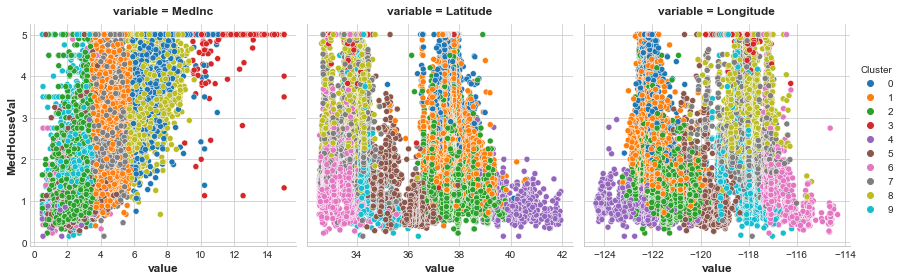

In [13]:
# 查看聚类和目标的关系
Course.inspect_relationship_between_k_means_label_and_target(X, y, features, label_y, label_cluster)

In [14]:
Course.score_dataset(X, y, scoring="neg_mean_squared_error")

0.652013931785248